In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from joblib import dump, load

import tqdm
from tqdm import tqdm

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [3]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
ids = mailout_test['LNR']
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [4]:
feat_df = pd.read_csv('./data/AZDIAS_Feature_Summary_r003.csv')
azdias = pd.read_csv('./data/cleaned/azdias_subset.csv')

In [5]:
cat_feats = ['CAMEO_DEU_2015','OST_WEST_KZ']
range_feats = ['GEBURTSJAHR','KBA13_ANZAHL_PKW','MIN_GEBAEUDEJAHR','MIN_GEBAEUDEJAHR']

feats = list(set(feat_df['Attribute']))
num_feats = [feat for feat in feats if feat not in cat_feats+range_feats]

all_feats = cat_feats + range_feats + num_feats
special_feats = cat_feats + range_feats

model_feats = [ feat for feat in list(azdias.columns) if feat != 'LNR']

len(cat_feats),len(range_feats),len(num_feats),len(all_feats),len(model_feats)

(2, 4, 309, 315, 271)

In [6]:
train_feat = list(mailout_train.columns)
test_feat = list(mailout_test.columns)

In [7]:
#Find model features not in customer features
model_feat_notin_train = [feat for feat in model_feats if feat not in train_feat]
model_feat_notin_test = [feat for feat in model_feats if feat not in test_feat]

len(model_feat_notin_train),len(model_feat_notin_test)

(0, 0)

# TRAIN

In [8]:
#Response DF LNR,REPONSE,CLUSTER_LABEL
train_response_df = pd.DataFrame()
train_response_df['LNR'] = mailout_train['LNR']
train_response_df['RESPONSE'] = mailout_train['RESPONSE']
train_response_df.head()

,LNR,RESPONSE
0,1763,0
1,1771,0
2,1776,0
3,1460,0
4,1783,0


In [21]:
# extra_columns = ['RESPONSE']
# mailout_train_extra = mailout_train[extra_columns  + ['LNR']]
# mailout_train = mailout_train.drop(extra_columns, axis=1)
mailout_train = mailout_train[model_feats]
#mailout_train = mailout_train.drop('LNR', axis=1)
mailout_train.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,8.0,NaN,NaN,1.0,NaN,5.0,21,2.0,0,...,3,3.0,NaN,2.0,6.0,9.0,3.0,3,2,4
1,1.0,13.0,1.0,NaN,2.0,NaN,5.0,19,2.0,1,...,4,2.0,NaN,1.0,4.0,9.0,7.0,1,2,3
2,1.0,9.0,NaN,NaN,NaN,NaN,1.0,8,4.0,0,...,7,3.0,NaN,1.0,NaN,9.0,2.0,3,1,4
3,2.0,6.0,4.0,NaN,2.0,NaN,2.0,8,2.0,0,...,2,1.0,NaN,2.0,6.0,9.0,1.0,3,2,4
4,2.0,9.0,NaN,NaN,1.0,NaN,4.0,31,6.0,0,...,7,1.0,NaN,1.0,6.0,9.0,3.0,3,1,3


In [22]:
mailout_train.shape

(42962, 271)

In [23]:
#FILLNA CATEGORICAL FEATS
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for cat in tqdm(cat_feats):
    mailout_train[cat] = mailout_train[cat].fillna('Unknown') 
    
    temp_list = []
    temp_df = feat_df[feat_df['Attribute'] == cat]
    values = [str(val) for val in temp_df['Value']]
    
    for val in mailout_train[cat]:
        try:
            val = str(val)
            if val in values:
                temp_list.append(val)
            else:
                temp_list.append('Unknown')
        except:
            temp_list.append('Unknown')
            
    mailout_train[str(cat)] = temp_list
    mailout_train[str(cat)] = le.fit_transform(mailout_train[cat])

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.67it/s]


In [24]:
#FILLNA NUMERICAL FEATS
mailout_train_num_feats = [col for col in mailout_train.columns if col in num_feats]

for cat in tqdm(mailout_train_num_feats):
    temp_list = []
    temp_df = feat_df[feat_df['Attribute'] == cat]
    values = [int(val) for val in temp_df['Value']]
    
    for val in mailout_train[cat]:
        try:
            val = int(val)
            if val in values:
                temp_list.append(val)
            else:
                temp_list.append(np.NaN)
        except:
            temp_list.append(np.NaN)
    mailout_train[str(cat)] = temp_list

100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:13<00:00, 19.87it/s]


In [25]:
#FILLNA RANGE FEATS
for feat in tqdm(range_feats):
    temp_list = []
    for val in mailout_train[feat]:
        try:
            val = int(val)
            temp_list.append(val)
        except:
            temp_list.append(np.NaN)
    mailout_train[feat] = temp_list

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 34.79it/s]


In [26]:
clean_mailout_train = mailout_train.fillna(mailout_train.mean())

In [27]:
clean_mailout_train.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,8.0,2.850165,1.310966,1.00000,1.081505,5.0,0,2.0,0,...,3,3.0,1.338028,2.0,6.000000,9.0,3.0,3,2,4
1,1.0,13.0,1.000000,1.310966,2.00000,1.081505,5.0,0,2.0,1,...,4,2.0,1.338028,1.0,4.000000,9.0,7.0,1,2,3
2,1.0,9.0,2.850165,1.310966,1.76496,1.081505,1.0,0,4.0,0,...,7,3.0,1.338028,1.0,4.590321,9.0,2.0,3,1,4
3,2.0,6.0,4.000000,1.310966,2.00000,1.081505,2.0,0,2.0,0,...,2,1.0,1.338028,2.0,6.000000,9.0,1.0,3,2,4
4,2.0,9.0,2.850165,1.310966,1.00000,1.081505,4.0,0,6.0,0,...,7,1.0,1.338028,1.0,6.000000,9.0,3.0,3,1,3


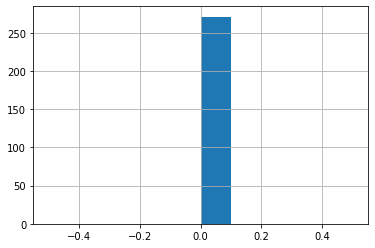

In [28]:
#figure out the nan per column
nans = clean_mailout_train.isna().sum().sort_values()
nans_df = pd.DataFrame()
nans_df['attr'] = list(nans.index)
nans_df['nan_count'] = list(nans.values)
len_df = clean_mailout_train.shape[0]
nans_df['pct_nan'] = [float(count)/len_df for count in nans_df['nan_count']]
nans_df['pct_nan'].hist()

In [29]:
nans_df[nans_df['pct_nan']>0]

,attr,nan_count,pct_nan


In [30]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

scaled_mailout_train = scaler.fit_transform(clean_mailout_train)
mailout_train = pd.DataFrame(scaled_mailout_train, columns=clean_mailout_train.columns)

In [31]:
mailout_train.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.651811,-1.251684,2.077321e-16,0.0,-1.254091,1.883594e-14,0.374223,0.0,-0.745525,-0.224018,...,-0.421575,1.176640,3.148610e-15,1.146944,0.907737,0.291966,-0.572127,0.174577,0.824885,0.736410
1,-1.218983,0.161261,-8.654534e-01,0.0,0.385328,1.883594e-14,0.374223,0.0,-0.745525,1.978334,...,0.053910,0.206405,3.148610e-15,-1.053221,-0.380126,0.291966,1.587486,-1.608634,0.824885,-0.200391
2,-1.218983,-0.969095,2.077321e-16,0.0,0.000000,1.883594e-14,-1.639828,0.0,0.389014,-0.224018,...,1.480366,1.176640,3.148610e-15,-1.053221,0.000000,0.291966,-1.112031,0.174577,-1.212290,0.736410
3,0.651811,-1.816862,5.378598e-01,0.0,0.385328,1.883594e-14,-1.136315,0.0,-0.745525,-0.224018,...,-0.897061,-0.763830,3.148610e-15,1.146944,0.907737,0.291966,-1.651934,0.174577,0.824885,0.736410
4,0.651811,-0.969095,2.077321e-16,0.0,-1.254091,1.883594e-14,-0.129290,0.0,1.523553,-0.224018,...,1.480366,-0.763830,3.148610e-15,-1.053221,0.907737,0.291966,-0.572127,0.174577,-1.212290,-0.200391


In [82]:
from joblib import dump, load

pca = load('dump/pca.joblib')

kmeans = load('dump/kmeans_model.joblib')

In [83]:
mailout_train_pca = pca.transform(mailout_train)
mailout_train_labels = kmeans.predict(mailout_train_pca)


In [84]:
train_label_df = pd.DataFrame(list(mailout_train_labels), columns=['CLUSTER_LABEL'])
train_label_df.head()

,CLUSTER_LABEL
0,35
1,15
2,25
3,18
4,2


In [85]:
train_response_df['CLUSTER_LABEL'] = train_label_df['CLUSTER_LABEL']
train_response_df.head()

,LNR,RESPONSE,CLUSTER_LABEL
0,1763,0,35
1,1771,0,15
2,1776,0,25
3,1460,0,18
4,1783,0,2


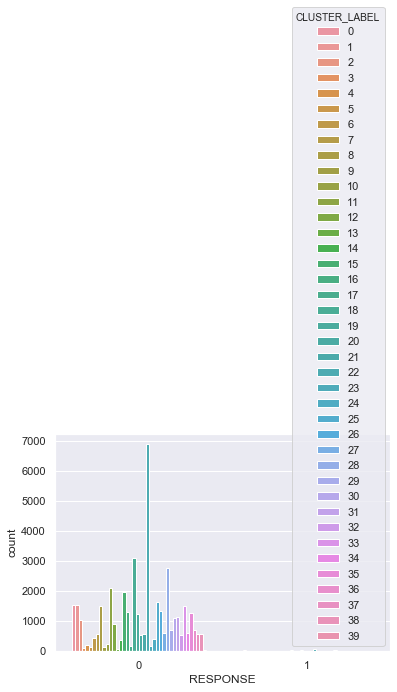

In [86]:
import seaborn as sns
sns.set(style="darkgrid")

ax = sns.countplot(x="RESPONSE", hue="CLUSTER_LABEL", data=train_response_df)

In [87]:
from imblearn.over_sampling import SMOTE

In [88]:
mailout_train.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.651811,-1.251684,2.077321e-16,0.0,-1.254091,1.883594e-14,0.374223,0.0,-0.745525,-0.224018,...,-0.421575,1.176640,3.148610e-15,1.146944,0.907737,0.291966,-0.572127,0.174577,0.824885,0.736410
1,-1.218983,0.161261,-8.654534e-01,0.0,0.385328,1.883594e-14,0.374223,0.0,-0.745525,1.978334,...,0.053910,0.206405,3.148610e-15,-1.053221,-0.380126,0.291966,1.587486,-1.608634,0.824885,-0.200391
2,-1.218983,-0.969095,2.077321e-16,0.0,0.000000,1.883594e-14,-1.639828,0.0,0.389014,-0.224018,...,1.480366,1.176640,3.148610e-15,-1.053221,0.000000,0.291966,-1.112031,0.174577,-1.212290,0.736410
3,0.651811,-1.816862,5.378598e-01,0.0,0.385328,1.883594e-14,-1.136315,0.0,-0.745525,-0.224018,...,-0.897061,-0.763830,3.148610e-15,1.146944,0.907737,0.291966,-1.651934,0.174577,0.824885,0.736410
4,0.651811,-0.969095,2.077321e-16,0.0,-1.254091,1.883594e-14,-0.129290,0.0,1.523553,-0.224018,...,1.480366,-0.763830,3.148610e-15,-1.053221,0.907737,0.291966,-0.572127,0.174577,-1.212290,-0.200391


In [89]:
X = mailout_train
y = train_response_df[['RESPONSE']]

In [90]:
resampler = SMOTE(random_state=777)
X_res, y_res = resampler.fit_sample(X, y.values)
print(X_res.shape, y_res.shape)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(84860, 271) (84860,)


In [91]:
x_df = pd.DataFrame(X_res, columns=X.columns)
y_df = pd.DataFrame(y_res, columns=y.columns)

In [92]:
smote_train_df = pd.merge(x_df , y_df, left_index=True, right_index=True)

In [93]:
smote_train_df.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,RESPONSE
0,0.651811,-1.251684,2.077321e-16,0.0,-1.254091,1.883594e-14,0.374223,0.0,-0.745525,-0.224018,...,1.176640,3.148610e-15,1.146944,0.907737,0.291966,-0.572127,0.174577,0.824885,0.736410,0
1,-1.218983,0.161261,-8.654534e-01,0.0,0.385328,1.883594e-14,0.374223,0.0,-0.745525,1.978334,...,0.206405,3.148610e-15,-1.053221,-0.380126,0.291966,1.587486,-1.608634,0.824885,-0.200391,0
2,-1.218983,-0.969095,2.077321e-16,0.0,0.000000,1.883594e-14,-1.639828,0.0,0.389014,-0.224018,...,1.176640,3.148610e-15,-1.053221,0.000000,0.291966,-1.112031,0.174577,-1.212290,0.736410,0
3,0.651811,-1.816862,5.378598e-01,0.0,0.385328,1.883594e-14,-1.136315,0.0,-0.745525,-0.224018,...,-0.763830,3.148610e-15,1.146944,0.907737,0.291966,-1.651934,0.174577,0.824885,0.736410,0
4,0.651811,-0.969095,2.077321e-16,0.0,-1.254091,1.883594e-14,-0.129290,0.0,1.523553,-0.224018,...,-0.763830,3.148610e-15,-1.053221,0.907737,0.291966,-0.572127,0.174577,-1.212290,-0.200391,0


In [94]:
smote_train_response_df = pd.DataFrame()
smote_train_response_df['RESPONSE'] = smote_train_df['RESPONSE']

In [95]:
smote_mailout_train_pca = pca.transform(x_df)
smote_mailout_train_labels = kmeans.predict(smote_mailout_train_pca)
smote_train_label_df = pd.DataFrame(list(smote_mailout_train_labels), columns=['CLUSTER_LABEL'])
smote_train_response_df['CLUSTER_LABEL'] = smote_train_label_df['CLUSTER_LABEL']
smote_train_response_df.head()

,RESPONSE,CLUSTER_LABEL
0,0,35
1,0,15
2,0,25
3,0,18
4,0,2


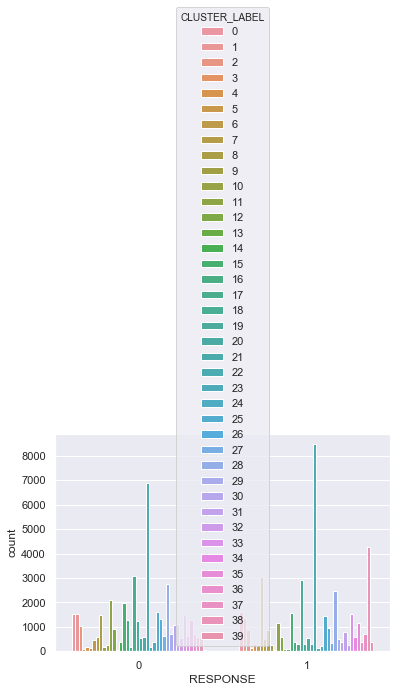

In [96]:
ax = sns.countplot(x="RESPONSE", hue="CLUSTER_LABEL", data=smote_train_response_df)

TRAIN THE MODEL

In [97]:
smote_train_df.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,RESPONSE
0,0.651811,-1.251684,2.077321e-16,0.0,-1.254091,1.883594e-14,0.374223,0.0,-0.745525,-0.224018,...,1.176640,3.148610e-15,1.146944,0.907737,0.291966,-0.572127,0.174577,0.824885,0.736410,0
1,-1.218983,0.161261,-8.654534e-01,0.0,0.385328,1.883594e-14,0.374223,0.0,-0.745525,1.978334,...,0.206405,3.148610e-15,-1.053221,-0.380126,0.291966,1.587486,-1.608634,0.824885,-0.200391,0
2,-1.218983,-0.969095,2.077321e-16,0.0,0.000000,1.883594e-14,-1.639828,0.0,0.389014,-0.224018,...,1.176640,3.148610e-15,-1.053221,0.000000,0.291966,-1.112031,0.174577,-1.212290,0.736410,0
3,0.651811,-1.816862,5.378598e-01,0.0,0.385328,1.883594e-14,-1.136315,0.0,-0.745525,-0.224018,...,-0.763830,3.148610e-15,1.146944,0.907737,0.291966,-1.651934,0.174577,0.824885,0.736410,0
4,0.651811,-0.969095,2.077321e-16,0.0,-1.254091,1.883594e-14,-0.129290,0.0,1.523553,-0.224018,...,-0.763830,3.148610e-15,-1.053221,0.907737,0.291966,-0.572127,0.174577,-1.212290,-0.200391,0


In [98]:
#split data
X = smote_train_df[clean_mailout_train.columns]
y = smote_train_df['RESPONSE']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 777)

### Random Forest

In [50]:
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True, max_depth=100) 

param_grid = { 
    'n_estimators': [100, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [250,500,1000,1500]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, verbose=10, n_jobs=-1)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.2min


KeyboardInterrupt: 

In [ ]:
#clf = RandomForestClassifier(n_estimators=175, max_depth=1000,random_state=10)
clf = RandomForestClassifier(n_estimators=700,random_state=10, max_features='sqrt')
rfc = clf.fit(X_train, y_train) 

In [ ]:
y_pred = rfc.predict(X_val)

print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

### XGBOOST

In [99]:
import xgboost as xgb
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [100]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

param_grid = { 
    'colsample_bytree': [0.1, 0.3,0.5],
    'n_estimators': [5, 10, 15],
    'alpha' : [10,15,20],
    'max_depth' : [5,10,15]
}

CV_xg_reg = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv= 5, verbose=10, n_jobs=-1)
CV_xg_reg.fit(X_train, y_train)
print(CV_xg_reg.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

{'alpha': 10, 'colsample_bytree': 0.5, 'max_depth': 15, 'n_estimators': 15}


In [101]:
CV_xg_reg.fit(X_train,y_train)

y_pred = CV_xg_reg.predict(X_val)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

In [102]:
print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

ROC AUC score for training: 0.9895624207877232


In [103]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print("RMSE: %f" % (rmse))

RMSE: 0.215503


In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

CV_xgb = GridSearchCV(estimator=xgb, param_grid=params, cv= 5, n_jobs=-1,verbose=10)

start_time = timer(None)
CV_xgb.fit(X_train, y_train)
timer(start_time)

print(CV_xgb.best_params_)

In [ ]:
y_pred = CV_xgb.predict(X_val)
print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

In [104]:
#export model
# dump(xgboost, './dump/xgboost.joblib')
# dump(rfc, './dump/rfc.joblib')
#dump(xg_reg, './dump/xg_reg.joblib')
dump(CV_xg_reg, './dump/cv_xg_reg.joblib')

['./dump/cv_xg_reg.joblib']

In [105]:
#import model
# xgboost = load('dump/xgboost.joblib')
# rfc = load('dump/rfc.joblib')
xg_reg = load('dump/cv_xg_reg.joblib')

# Test Model

In [63]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [64]:
mailout_test = mailout_test[clean_mailout_train.columns]
mailout_test.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2,7.0,2.0,0.0,2.0,0.0,6.0,2B,5.0,0,...,7,3,0.0,1,6.0,9.0,3.0,3,1,4
1,-1,0.0,20.0,0.0,1.0,0.0,7.0,5A,1.0,0,...,6,2,0.0,1,6.0,9.0,5.0,3,1,4
2,2,16.0,2.0,0.0,4.0,0.0,1.0,7A,2.0,0,...,3,3,0.0,1,2.0,9.0,4.0,3,2,4
3,-1,0.0,1.0,0.0,0.0,0.0,1.0,2B,4.0,0,...,2,3,0.0,2,NaN,9.0,2.0,3,2,4
4,1,21.0,1.0,0.0,4.0,0.0,6.0,5A,6.0,3,...,3,3,0.0,1,3.0,9.0,7.0,4,2,4


In [65]:
X_test = mailout_test

In [66]:
X_test.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2,7.0,2.0,0.0,2.0,0.0,6.0,2B,5.0,0,...,7,3,0.0,1,6.0,9.0,3.0,3,1,4
1,-1,0.0,20.0,0.0,1.0,0.0,7.0,5A,1.0,0,...,6,2,0.0,1,6.0,9.0,5.0,3,1,4
2,2,16.0,2.0,0.0,4.0,0.0,1.0,7A,2.0,0,...,3,3,0.0,1,2.0,9.0,4.0,3,2,4
3,-1,0.0,1.0,0.0,0.0,0.0,1.0,2B,4.0,0,...,2,3,0.0,2,NaN,9.0,2.0,3,2,4
4,1,21.0,1.0,0.0,4.0,0.0,6.0,5A,6.0,3,...,3,3,0.0,1,3.0,9.0,7.0,4,2,4


In [67]:
#FILLNA CATEGORICAL FEATS
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for cat in tqdm(cat_feats):
    X_test[cat] = X_test[cat].fillna('Unknown') 
    
    temp_list = []
    temp_df = feat_df[feat_df['Attribute'] == cat]
    values = [str(val) for val in temp_df['Value']]
    
    for val in X_test[cat]:
        try:
            val = str(val)
            if val in values:
                temp_list.append(val)
            else:
                temp_list.append('Unknown')
        except:
            temp_list.append('Unknown')
            
    X_test[str(cat)] = temp_list
    X_test[str(cat)] = le.fit_transform(X_test[cat])

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.36it/s]


In [68]:
#FILLNA NUMERICAL FEATS
test_num_feats = [col for col in mailout_test.columns if col in num_feats]

for cat in tqdm(test_num_feats):
    temp_list = []
    temp_df = feat_df[feat_df['Attribute'] == cat]
    values = [int(val) for val in temp_df['Value']]
    
    for val in X_test[cat]:
        try:
            val = int(val)
            if val in values:
                temp_list.append(val)
            else:
                temp_list.append(np.NaN)
        except:
            temp_list.append(np.NaN)
    X_test[str(cat)] = temp_list

100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:13<00:00, 19.85it/s]


In [69]:
#FILLNA RANGE FEATS
for feat in tqdm(range_feats):
    temp_list = []
    for val in X_test[feat]:
        try:
            val = int(val)
            temp_list.append(val)
        except:
            temp_list.append(np.NaN)
    X_test[feat] = temp_list

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 32.00it/s]


In [70]:
X_test = X_test.fillna(X_test.mean())

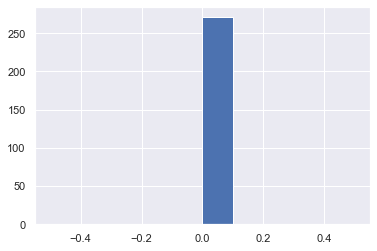

In [71]:
#figure out the nan per column
nans = X_test.isna().sum().sort_values()
nans_df = pd.DataFrame()
nans_df['attr'] = list(nans.index)
nans_df['nan_count'] = list(nans.values)
len_df = X_test.shape[0]
nans_df['pct_nan'] = [float(count)/len_df for count in nans_df['nan_count']]
nans_df['pct_nan'].hist()

In [72]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns=mailout_test.columns)

In [73]:
X_test.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.666667,0.263158,0.111111,0.029947,0.500000,0.045833,0.833333,0.136364,0.8,0.0,...,1.000000,1.000000,0.096545,0.0,1.000000,1.0,0.375,0.4,0.0,0.375
1,0.550505,0.549118,0.203368,0.029947,0.000000,0.045833,1.000000,0.409091,0.0,0.0,...,0.833333,0.666667,0.096545,0.0,1.000000,1.0,0.625,0.4,0.0,0.375
2,0.666667,0.736842,0.111111,0.029947,0.385238,0.045833,0.000000,0.681818,0.2,0.0,...,0.333333,1.000000,0.096545,0.0,0.200000,1.0,0.500,0.4,1.0,0.375
3,0.550505,0.549118,0.000000,0.029947,0.385238,0.045833,0.000000,0.136364,0.6,0.0,...,0.166667,1.000000,0.096545,1.0,0.717497,1.0,0.250,0.4,1.0,0.375
4,0.333333,1.000000,0.000000,0.029947,0.385238,0.045833,0.833333,0.409091,1.0,0.5,...,0.333333,1.000000,0.096545,0.0,0.400000,1.0,0.875,0.6,1.0,0.375


In [74]:
#y_pred = xg_reg.predict_proba(X_test)

In [106]:
y_pred = xg_reg.predict(X_test)

In [107]:
y_pred

array([0.8357299, 0.6947213, 0.6715894, ..., 0.8182574, 0.7775023,
       0.8001539], dtype=float32)

In [108]:
submission_df = pd.DataFrame()
submission_df['LNR'] = ids
#submission_df['PROB_0'] = [ probs[0] for probs in y_pred ]
#submission_df['PROB_1'] = [ probs[1] for probs in y_pred ]
submission_df['PREDICTION'] = y_pred

In [109]:
submission_df.head()

,LNR,PREDICTION
0,1754,0.835730
1,1770,0.694721
2,1465,0.671589
3,1470,0.770385
4,1478,0.747741


In [110]:
submission_df['PREDICTION'].value_counts()

0.895749    7157
0.894213     528
0.872804     410
0.820641     359
0.823383     312
0.855286     277
0.747958     239
0.747440     239
0.763603     237
0.896328     225
0.872225     221
0.822804     193
0.690920     191
0.776198     186
0.746541     170
0.803579     168
0.716418     163
0.773456     161
0.677045     154
0.854707     146
0.850764     145
0.846907     139
0.620007     138
0.673340     134
0.844165     130
0.793726     128
0.690402     123
0.878811     123
0.808101     123
0.849921     119
            ... 
0.794172       1
0.708894       1
0.583888       1
0.771381       1
0.794193       1
0.646377       1
0.793992       1
0.646526       1
0.584028       1
0.646530       1
0.771750       1
0.793729       1
0.731256       1
0.668808       1
0.695041       1
0.771700       1
0.793900       1
0.771687       1
0.771680       1
0.606419       1
0.731432       1
0.709157       1
0.606433       1
0.731436       1
0.709136       1
0.771626       1
0.793980       1
0.847433      

In [111]:
submission_df.shape

(42833, 2)

In [112]:
submit = pd.DataFrame()
submit['LNR'] = submission_df['LNR']
submit['RESPONSE'] = submission_df['PREDICTION']

In [113]:
submit.to_csv('./data/submission.csv', index=False)